In [60]:
import numpy as np
import scipy as sp
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import matplotlib.pyplot as plt
%matplotlib inline

https://www.pnas.org/content/110/45/E4185

## Hopfield model

## $\tau \frac { d u _ { i } } { d t } = - u _ { i }(t) + \sum _ { j = 1 } ^ { N } T _ { ij } f _ { j } \left( u _ { j } (t)\right) + I _ { i }(t)$

-Hopfield: $T_{ij}$ is PSD

-Functional feedforward: $T_{ij}$ is non-normal, with off-diagonal terms shown in Schur decomposition

-Seuqnece activity: $T_{ij}$ has dominating elements along $i^{th}$ rows and the convarinace matrix would be eye-like

In [269]:
###Tij matrix
N = 20
temp = np.random.randn(1,N)
T = np.dot(temp.T,temp)
T = T/N

In [338]:
###functional feedforward
temp = np.random.randn(1,N)
T = np.dot(temp.T,temp)
u,s,v = np.linalg.svd(T)
temp2 = np.random.randn(N,N)
ss = np.diag(s) + np.triu(temp2, k=1)*1  #with feedforward term in Schur decomposition
T = u @ ss @ v
T = T/N

In [441]:
###sequence?
temp = np.random.randn(1,N)
T = np.dot(temp.T,temp)
temp2 = np.eye(N)
rr = np.arange(N)
np.random.shuffle(rr)
temp3 = np.take(temp2, rr, axis=0)  #seqeunce feedforward matrix
T = T + temp3*30
T = T/N

###Nonlinearity
def NL(u,the):
    return np.array([min(np.max(ui-the,0),10) for ui in u]) #ReLu

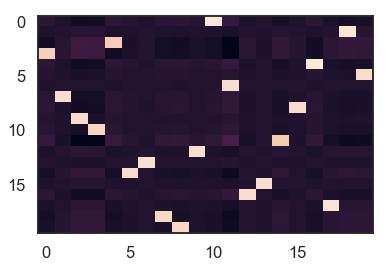

In [442]:
plt.imshow(T,aspect='auto')

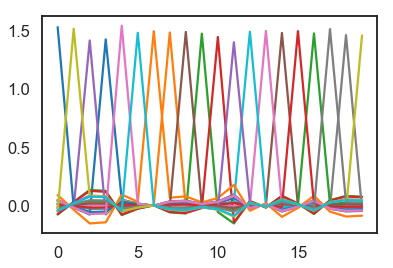

In [443]:
plt.plot(T);

In [450]:
###Dynamics
TT = 10
dt = 0.01
time = np.arange(0,TT,dt)
u = np.zeros((N,len(time)))
u[:,0] = np.random.randn(N)
tau = 0.05  #time scale
the = 0  #threshold
beta = .3  #global inhibition

for tt in range(len(time)-1):
    u[:,tt+1] = u[:,tt] + dt*(-u[:,tt] + np.dot(T,NL(u[:,tt]-beta*np.sum(u[:,tt]),the)))/tau + np.random.randn(N)*0.
    #u[:,tt+1] = u[:,tt] + dt*(-u[:,tt] + NL(np.dot(T,u[:,tt])-beta*np.sum(u[:,tt]),the))/tau + np.random.randn(N)*1.
                              

Text(0, 0.5, 'activity')

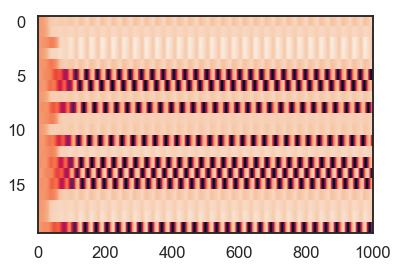

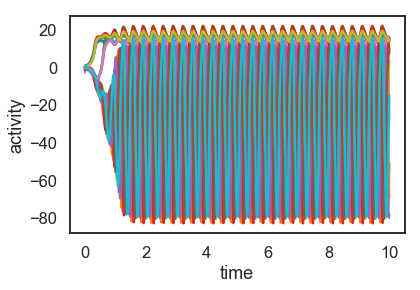

In [462]:
plt.imshow(u,aspect='auto')
plt.figure()
plt.plot(time,u.T);
plt.xlabel('time')
plt.ylabel('activity')

Text(0, 0.5, '|Y(freq)|')

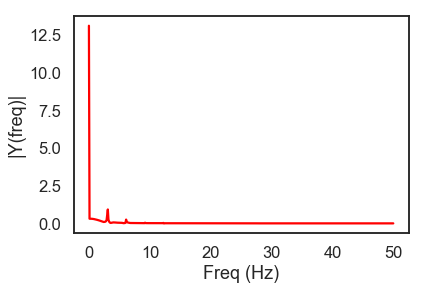

In [463]:
###Spectrum
Fs = int(1/dt);  # sampling rate
Ts = 1.0/Fs; # sampling interval

n = u.shape[1] # length of the signal
k = np.arange(n)
Tf = n/Fs
frq = k/Tf # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(u[0,:])/n # fft computing and normalization
Y = Y[range(int(n/2))]

plt.plot(frq[:],abs(Y)[:],'r') # plotting the spectrum
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')


Text(0, 0.5, 'activity')

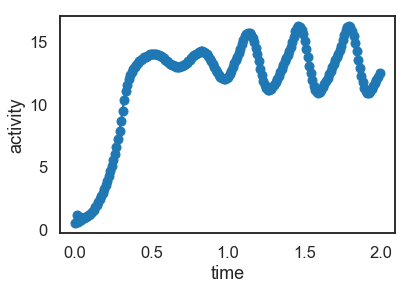

In [464]:
plt.plot(time[:200],u[0,:200].T,'-o');
plt.xlabel('time')
plt.ylabel('activity')